Source: https://github.com/clcarwin/examples/tree/master/fast_neural_style

### setup

In [1]:
import os
import argparse
import time

In [2]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchnet.meter import AverageValueMeter

In [4]:
# parameters
parser = {
    'data_path': '../data/coco/',
    'style_image': '../data/starry_night.jpg',
    'test_image': '../data/chicago.jpg',
    'epochs': 2,
    'batch_size': 1,
    'lr': 0.001,
    'image_size': 256,
    'style_size': 256,
    'content_weight': 1.0,
    'style_weight': 5.0,
    'cuda': True,
    'seed': 7,
    'workers': 4,
    'log_interval': 1000,
    'intermediate_path': '../intermediate/fastneuralstyle/',
}
args = argparse.Namespace(**parser)

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
    
if not os.path.isdir(args.intermediate_path):
    os.makedirs(args.intermediate_path)

args.cuda = args.cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [5]:
model_filename = args.style_image.split('/')[-1].split('.')[0] + '.pth'
model_filepath = os.path.join(args.intermediate_path, model_filename)

### model

In [6]:
class VGGFeature(nn.Module):
    def __init__(self):
        super(VGGFeature, self).__init__()
        vgg16 = models.vgg16()
        self.f1 = nn.Sequential(*list(vgg16.features.children())[0:4])
        self.f2 = nn.Sequential(*list(vgg16.features.children())[5:9])
        self.f3 = nn.Sequential(*list(vgg16.features.children())[10:16])
        self.f4 = nn.Sequential(*list(vgg16.features.children())[17:23])
        
    def forward(self, x):
        f1 = self.f1(x)
        x = F.max_pool2d(f1, kernel_size=2, stride=2)
        f2 = self.f2(x)
        x = F.max_pool2d(f2, kernel_size=2, stride=2)
        f3 = self.f3(x)
        x = F.max_pool2d(f3, kernel_size=2, stride=2)
        f4 = self.f4(x)
        return [f1, f2, f3, f4]

In [7]:
# redidual block for style model
class ResidualBlock(nn.Module):
    def __init__(self, num):
        super(ResidualBlock, self).__init__()
        self.c1 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(num)
        self.b2 = nn.BatchNorm2d(num)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = self.b2(self.c2(h))
        return h + x

In [8]:
# style model
class FastStyleNet(nn.Module):
    def __init__(self):
        super(FastStyleNet, self).__init__()
        self.c1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.c2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.c3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.r1 = ResidualBlock(128)
        self.r2 = ResidualBlock(128)
        self.r3 = ResidualBlock(128)
        self.r4 = ResidualBlock(128)
        self.r5 = ResidualBlock(128)
        self.d1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2,
                                     padding=1)
        self.d2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,
                                     padding=1)
        self.d3 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)
        self.b1 = nn.BatchNorm2d(32)
        self.b2 = nn.BatchNorm2d(64)
        self.b3 = nn.BatchNorm2d(128)
        self.b4 = nn.BatchNorm2d(64)
        self.b5 = nn.BatchNorm2d(32)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = F.relu(self.b2(self.c2(h)))
        h = F.relu(self.b3(self.c3(h)))
        h = self.r1(h)
        h = self.r2(h)
        h = self.r3(h)
        h = self.r4(h)
        h = self.r5(h)
        h = F.relu(self.b4(self.d1(h)))
        h = F.relu(self.b5(self.d2(h)))
        y = self.d3(h)
        return y

### utils

In [9]:
# this torch7 model is trained with BGR [0,255]
def download_convert_vgg16_model(filepath):
    if not os.path.exists(filepath):
        t7_filepath = os.path.join(args.intermediate_path, 'vgg16.t7')
        if not os.path.exists(t7_filepath):
            URL = "http://cs.stanford.edu/people/jcjohns/"\
                  "fast-neural-style/models/vgg16.t7"
            !wget -O $t7_filepath $URL
        vgglua = load_lua(t7_filepath)
        vgg = VGGFeature()
        for (src, dst) in zip(vgglua.parameters()[0], vgg.parameters()):
            dst.data[:] = src
        torch.save(vgg.state_dict(), filepath)

In [10]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [11]:
# batch: Bx3xHxW BGR [0,255] Variable
def vgg_preprocessing(batch):
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    batch -= Variable(mean)

In [12]:
# batch: Bx3xHxW
def batch_rgb_to_bgr(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [13]:
# result: RGB CxHxW [0,255] torch.FloatTensor
def tensor_load_rgbimage(filename, size=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)  # HWC->CHW
    img = torch.from_numpy(img).float()
    return img

### train

In [14]:
def train(args, data_loader, model, feature_model, style_gram, criterion,
          optimizer, epoch):
    model.train()
    content_losses = AverageValueMeter()
    style_losses = AverageValueMeter()
    losses = AverageValueMeter()
    start = time.time()
    n_batch = 1 + (len(data_loader.dataset)-1) // args.batch_size
    
    for i, (image, _) in enumerate(data_loader):
        batch_size = image.size(0)
        image = batch_rgb_to_bgr(image)
        if args.cuda:
            image = image.cuda()
        image = Variable(image)
        
        image_hat = model(image)
        vgg_preprocessing(image_hat)
        image_hat_features = feature_model(image_hat)
        image_hat_gram = [gram_matrix(feature)
                          for feature in image_hat_features]
        
        image_copy = Variable(image.data, volatile=True)
        vgg_preprocessing(image_copy)
        # not .detach() here because of 'volatile'
        image_feature = Variable(feature_model(image_copy)[1].data)
        content_loss = args.content_weight * criterion(image_hat_features[1],
                                                       image_feature)
        
        style_loss = 0
        for (ig, sg) in zip(image_hat_gram, style_gram):
            style_loss += args.style_weight * criterion(ig, sg[:batch_size])
        
        loss = content_loss + style_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        content_losses.add(content_loss.data.cpu()[0] * batch_size,
                           batch_size)
        style_losses.add(style_loss.data.cpu()[0] * batch_size, batch_size)
        losses.add(loss.data.cpu()[0] * batch_size, batch_size)
        
        if (i+1) % args.log_interval == 0:
            print("=> EPOCH {} [{}/{}] | Time: {}s | Content loss: {}"
                  " | Style loss: {} | Total loss: {}"
                  .format(epoch, i+1, n_batch,
                          round(time.time()-start),
                          round(content_losses.value()[0]),
                          round(style_losses.value()[0]),
                          round(losses.value()[0])))
            start = time.time()
            content_losses.reset()
            style_losses.reset()
            losses.reset()
    if len(data_loader.dataset) % args.batch_size != 0:
        print("=> EPOCH {} [{}/{}] | Time: {}s | Content loss: {}"
              " | Style loss: {} | Total loss: {}"
              .format(epoch, n_batch, n_batch,
                      round(time.time()-start),
                      round(content_losses.value()[0]),
                      round(style_losses.value()[0]),
                      round(losses.value()[0])))

### prepare

In [15]:
transform = transforms.Compose([transforms.Scale(args.image_size),
                                transforms.CenterCrop(args.image_size),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.mul(255))])
data_loader = DataLoader(datasets.ImageFolder(args.data_path, transform),
                         batch_size=args.batch_size,
                         shuffle=True, num_workers=args.workers)

In [16]:
vgg16_filepath = os.path.join(args.intermediate_path, 'vgg16feature.pth')
download_convert_vgg16_model(vgg16_filepath)
vgg = VGGFeature()
vgg.load_state_dict(torch.load(vgg16_filepath))

model = FastStyleNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

if args.cuda:
    vgg.cuda()
    model.cuda()
    criterion.cuda()

In [17]:
# style gram
style = tensor_load_rgbimage(args.style_image, args.style_size)
style = style.repeat(args.batch_size, 1, 1, 1)
style = batch_rgb_to_bgr(style)

if args.cuda:
    style = style.cuda()
style = Variable(style, volatile=True)
vgg_preprocessing(style)
style_features = vgg(style)
style_gram = [Variable(gram_matrix(feature).data)
              for feature in style_features]

### run

In [18]:
for epoch in range(1, args.epochs+1):
    train(args, data_loader, model, vgg, style_gram, criterion,
          optimizer, epoch)

=> EPOCH 1 [0/82783] | Time: 0s | Content loss: 227967 | Style loss: 4460970 | Total loss: 4688938
=> EPOCH 1 [1000/82783] | Time: 116s | Content loss: 204903 | Style loss: 387232 | Total loss: 592135
=> EPOCH 1 [2000/82783] | Time: 117s | Content loss: 182288 | Style loss: 226818 | Total loss: 409107
=> EPOCH 1 [3000/82783] | Time: 118s | Content loss: 167419 | Style loss: 170495 | Total loss: 337915
=> EPOCH 1 [4000/82783] | Time: 117s | Content loss: 157132 | Style loss: 141673 | Total loss: 298806
=> EPOCH 1 [5000/82783] | Time: 117s | Content loss: 149518 | Style loss: 123757 | Total loss: 273276
=> EPOCH 1 [6000/82783] | Time: 117s | Content loss: 143140 | Style loss: 111392 | Total loss: 254533
=> EPOCH 1 [7000/82783] | Time: 117s | Content loss: 138396 | Style loss: 102476 | Total loss: 240873
=> EPOCH 1 [8000/82783] | Time: 117s | Content loss: 134308 | Style loss: 95578 | Total loss: 229886
=> EPOCH 1 [9000/82783] | Time: 117s | Content loss: 130786 | Style loss: 90017 | Tota

In [19]:
torch.save(model.state_dict(), model_filepath)

In [20]:
del model

### test

In [21]:
model = FastStyleNet()
model.load_state_dict(torch.load(model_filepath))
if args.cuda:
    model.cuda()
model.eval()

FastStyleNet (
  (c1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (r1): ResidualBlock (
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (r2): ResidualBlock (
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (r3): ResidualBlock (
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel

In [22]:
img = tensor_load_rgbimage(args.test_image)
img = img.unsqueeze(0)
img = batch_rgb_to_bgr(img)
if args.cuda:
    img = img.cuda()
img = Variable(img, volatile=True)

In [23]:
output = model(img)
output = output.data.cpu().clamp(0, 255).byte().numpy()
output = output[0].transpose((1, 2, 0))
output = output[..., ::-1]

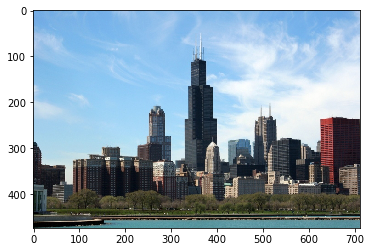

In [25]:
plt.imshow(Image.open(args.test_image))

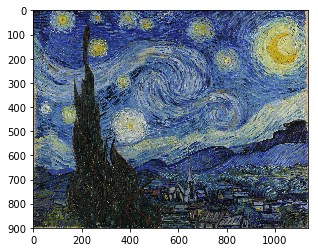

In [26]:
plt.imshow(Image.open(args.style_image))

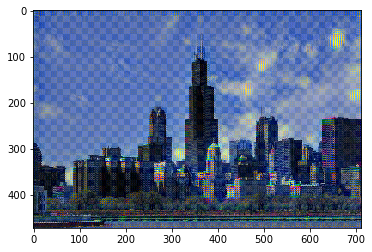

In [27]:
plt.imshow(output)